# Undestanding the opioid crisis with a modified epidemic model
----

In [2]:
import numpy as np
import pandas as pd
import scipy as sp
import time
pd.set_option('display.max_rows', 999)
pd.set_option('display.width', 500)
pd.set_option('display.notebook_repr_html', True)
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Import data

In [10]:
data = pd.read_csv('NCHS_-_Drug_Poisoning_Mortality_by_State__United_States (1).csv')
data.columns = [u'Year', u'Sex', u'Age', u'Race', u'State', 
                u'Deaths', u'Population', u'Crude Death Rate', 
                u'Standard Error for Crude Rate', u'Low Confidence Limit for Crude Rate', 
                u'Upper Confidence Limit for Crude Rate', u'Age-adjusted Rate', 
                u'Standard Error Age-adjusted Rate', 
                u'Lower Confidence Limit for Age-adjusted rate', 
                u'Upper Confidence Limit for Age-adjusted Rate', 
                u'State Crude Rate in Range', u'US Crude Rate', 
                u'US Age-adjusted Rate']

data = data.query('Age== "All Ages" & Sex=="Both Sexes" & Race=="All Races-All Origins" & State!="United States"')

data['Deaths'] = data['Deaths'].apply(lambda x: x.replace(',',''))
data['Deaths'] = pd.to_numeric(data['Deaths'], errors='coerce')
data['Population'] = data['Population'].apply(lambda x: x.replace(',',''))
data['Population'] = pd.to_numeric(data['Population'], errors='coerce')
data['Age-adjusted Rate'] = data['Age-adjusted Rate']*data['Population']/100000

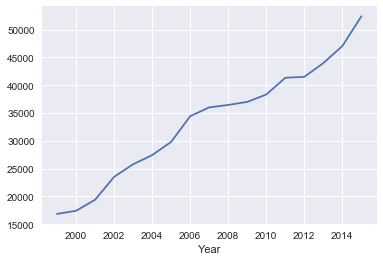

In [17]:
yearly_deaths = data.groupby(['Year'])['Deaths'].sum()
yearly_deaths.plot()

### The system of equations

In [3]:
def opioid(state, t, awareness_effect, epsilon, beta, xi, gamma, zeta, delta, nu, sigma, mu, mu_star):
    S, P, A, R, alpha = state
    S_prime = -alpha*S - beta*(1-xi)*S*A - beta*xi*S*P + epsilon*P + delta*R + mu*(P+R) + mu_star*A
    P_prime = alpha*S - (epsilon + gamma + mu)*P
    A_prime = gamma*P + sigma*R + beta*(1-xi)*S*A + beta*xi*S*P + nu*R*A - (zeta + mu_star)*A
    R_prime = zeta*A - nu*R*A - (delta + sigma + mu)*R
    alpha_prime = awareness_effect * (1-(A + R))
    return [S_prime, P_prime, A_prime, R_prime, alpha_prime]

### Our parameters

In [96]:
# parameters
epsilon = 0.74 # P to S rate
xi = 0.505 #  fraction of beta due to P
gamma = 0.26 # rate of addiction among prescribed users
nu = 0.2 # relapse rate of R due to A pressure
sigma = 0.7 # natural relapse rate of R 
mu = 0.00824 # death rate
mu_star = 0.00834 # death rate of addicts

delta = 0.1 # R to S rate. 0.1 is default
beta = 0.0625 # total addiction rate for S due to illegal access

alpha = 0.5 # prescription rate. could be 0-1
zeta = 0.5 # rate of A entry into rehab. could be 0-1

# Need to enforce sigma + nu + delta = 1 and epsilon + gamma = 1
awareness_effect = 0.001

print (epsilon + gamma)
sigma + nu + delta

1.0


0.9999999999999999

In [5]:
state0 = [0.87, 0.1, 0.02, 0.01, 0.2] # S P A R alpha
t = np.linspace(0, 75, 1501)

In [6]:
numerical_sol = sp.integrate.odeint(opioid, state0, t, args=(awareness_effect, epsilon, beta, xi, gamma, zeta, delta, nu, sigma, mu, mu_star))

S = numerical_sol[:,0]
P = numerical_sol[:,1]
A = numerical_sol[:,2]
R = numerical_sol[:,3]
alp = numerical_sol[:,4]

(0, 1)

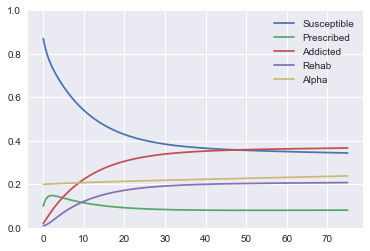

In [7]:
plt.plot(t, S, label="Susceptible")
plt.plot(t, P, label="Prescribed")
plt.plot(t, A, label="Addicted")
plt.plot(t, R, label="Rehab")
plt.plot(t, alp, label="Alpha")
plt.legend()
plt.ylim(0, 1)

In [226]:
def opioid_ours(state, t, alpha, beta_1, beta_2, xi, gamma, zeta, delta, nu, sigma, mu, mu_star):
    
    '''epsilon was defined to be the prescribed to susceptible rate, but has the
    constraint that it is equal to 1 - gamma.
    
    delta is defined to be the rate of recovery, and is assumed to be 1 - sigma - nu*A
    '''
    S, P, A, R = state
    nu = (1 - sigma - delta - mu)/A
    S_prime = -alpha*S - beta_1*S*A - beta_2*S*P + (1-gamma)*P + delta*R + mu*(P+R) + mu_star*A
    P_prime = alpha*S - (1 + mu)*P
    A_prime = gamma*P + sigma*R + beta_1*S*A + beta_2*S*P + nu*R*A - (zeta + mu_star)*A
    R_prime = zeta*A - nu*R*A - (delta + sigma + mu)*R
    return [S_prime, P_prime, A_prime, R_prime]

In [186]:
# parameters
epsilon = 0.74 # Prescribed to Susceptible rate
gamma = 0.26 # rate of addiction among prescribed users
gamma = 0.08
sigma = 0.7 # natural relapse rate of R 
mu = 0.00824 # death rate
mu_star = 0.023 #0.0235275 what I think it should be
delta = 0.6 # R to S rate. 0.1 is default
beta_1 = 0.0625 # total addiction rate for Susceptible due to illegal access
beta_2 = 0.0625 # total addiction rate for Susceptible due to illegal access
alpha = 0.3 # prescription rate. could be 0-1
zeta = 0.7 # rate of A entry into rehab. could be 0-1

In [193]:
def opioid_deaths(t, alpha, beta_1, beta_2, xi, gamma, zeta, delta, nu, sigma, mu, mu_star):
    
    state0 = [0.87, 0.11, 0.01, 0.01] #S P A R
    
    numerical_sol = sp.integrate.odeint(opioid_ours, state0, t,
                                        args=(alpha, beta_1, beta_2, xi, gamma, zeta, delta, nu, sigma, mu, mu_star))

    S = numerical_sol[:,0]
    P = numerical_sol[:,1]
    A = numerical_sol[:,2]
    R = numerical_sol[:,3]
    
    predicted_deaths = A * (mu_star - mu) * 0.10 # A * (mu_star - mu)
    return predicted_deaths

In [194]:
fitted_params, _ = sp.optimize.curve_fit(opioid_deaths, t, yearly_deaths.values/(320 * 10**6),
                                         maxfev=8000)
fitted_params

/Users/makmana/env/lib/python3.6/site-packages/scipy/optimize/minpack.py:785: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


array([  1.27776361e+02,   3.69485418e+01,   1.12778245e+02,
         1.00000000e+00,   1.40489779e+02,   2.20842861e+01,
         4.85603980e+01,   1.00000000e+00,  -3.70973589e+01,
         3.35454357e+03,   3.35461607e+03])

https://stackoverflow.com/questions/16541171/how-do-i-put-a-constraint-on-scipy-curve-fit

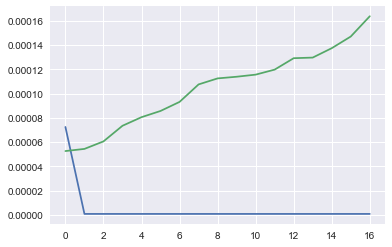

In [195]:
plt.plot(t, opioid_deaths(t, *fitted_params))
plt.plot(t, yearly_deaths.values /320000000)

In [228]:
def opioid_deaths2(t, alpha, beta_1, beta_2, zeta, gamma, mu_star):
    
    state0 = [0.87, 0.10, 0.02, 0.01] #S P A R
    
    numerical_sol = sp.integrate.odeint(opioid_ours, state0, t,
                                        args=(alpha, beta_1, beta_2, xi, gamma, zeta, delta, nu, sigma, mu, mu_star))

    S = numerical_sol[:,0]
    P = numerical_sol[:,1]
    A = numerical_sol[:,2]
    R = numerical_sol[:,3]
    
    opioid_deaths = A * (mu_star - mu)
    
    return opioid_deaths

In [229]:
t = np.linspace(0, 17, 17)

In [256]:
fitted_params, _ = sp.optimize.curve_fit(opioid_deaths, t, yearly_deaths.values/(320 * 10**6),
                                         maxfev=8000,
                                         method="trf",
                                         bounds=((0,0, 0, 0, 0, 0, 0, 0, 0, 0, 0), (1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1))
                                        )
fitted_params

array([ 0.154872  ,  0.5913556 ,  0.23111976,  0.5       ,  0.20116958,
        0.25747987,  0.29781963,  0.5       ,  0.50000001,  0.47736586,
        0.48713438])

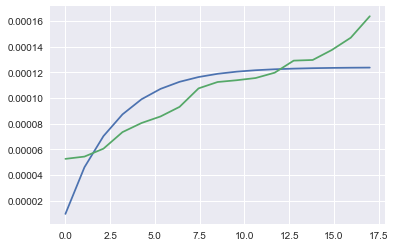

In [260]:
plt.plot(t, opioid_deaths(t, *fitted_params))
plt.plot(t, yearly_deaths.values /320000000)

In [288]:
def opioid_deaths3(t, P, A, R, alpha, beta_1, beta_2, zeta, gamma, mu_star):
    
    S = 1 - (P + A + R)
    state0 = [S, P, A, R] #S P A R
    
    numerical_sol = sp.integrate.odeint(opioid_ours, state0, t,
                                        args=(alpha, beta_1, beta_2, xi, gamma, zeta, delta, nu, sigma, mu, mu_star))

    opioid_deaths = numerical_sol[:,2] * (mu_star - mu)
    
    return opioid_deaths

In [289]:
fitted_params, _ = sp.optimize.curve_fit(opioid_deaths3, t, yearly_deaths.values/(320 * 10**6),
                                         maxfev=8000,
                                         method="trf",
                                         bounds=(
                                         (0, 0, 0, 0, 0, 0, 0, 0, 0),
                                         (0.30, 0.05, 0.05, 1, 1, 1, 1, 1, 1)
                                         )
                                        )
fitted_params

array([ 0.00607623,  0.00155636,  0.00234918,  0.03808095,  0.04077651,
        0.03761404,  0.96156974,  0.03737352,  0.03535628])

In [290]:
P, A, R, alpha, beta_1, beta_2, zeta, gamma, mu_star = fitted_params

In [291]:
state0 = [1 - (P + A + R), P, A, R]

numerical_sol = sp.integrate.odeint(opioid_ours, state0, t,
                                    args=(alpha, beta_1, beta_2, xi, gamma, zeta, delta, nu, sigma, mu, mu_star))

S = numerical_sol[:,0]
P = numerical_sol[:,1]
A = numerical_sol[:,2]
R = numerical_sol[:,3]

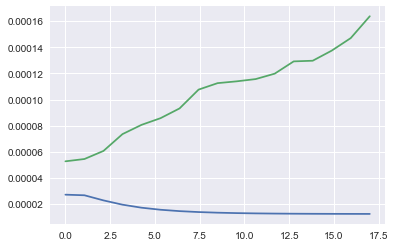

In [292]:
plt.plot(t, opioid_deaths(t, alpha, beta_1, beta_2, xi, gamma, zeta, delta, nu, sigma, mu, mu_star))
plt.plot(t, yearly_deaths.values /320000000)

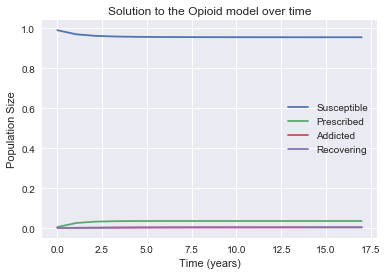

In [293]:
plt.plot(t, S, label="Susceptible")
plt.plot(t, P, label= "Prescribed")
plt.plot(t, A, label= "Addicted")
plt.plot(t, R, label= "Recovering")
plt.title("Solution to the Opioid model over time")

plt.xlabel("Time (years)")
plt.ylabel("Population Size")
plt.legend()

